## Note

The first two examples given here require the sobol_seq package for Sobol sequence sampling. 
This package can be installe using conda

conda install -c https://conda.binstar.org/naught101 sobol_seq

or  pip

pip install sobol_seq

***
*** 

In [1]:
import pandas as pd
import numpy as np
import random 
from hdmr2 import rshdmr
import sobol_seq

from sklearn.linear_model import ARDRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from itertools import combinations 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

from scipy import stats
from pyDOE import lhs

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
def generate_samples(n,samples, design='sobol'):
    if design == 'sobol' :
        S = sobol_seq.i4_sobol_generate(n, samples)
    if design == 'lhs' :
        S = lhs(n, samples=samples, criterion='center')
    return S

def get_column_labels(n):
    column_labels = []
    for column_index in range(1,n+1):
        column_labels.append('x' + str(column_index)) 
    return column_labels


def total_effects(instance, labels='all', lower_p = 0.025, upper_p = 0.975, alpha=1 ):
    bootstrap = instance.boot
    bootstrap.set_index(instance.sobol_indexes['index'], inplace=True)
    
    if labels == 'all' :
        all_list = []
        for i in bootstrap.index:
            all_list = test + i.split(',')
        my_indices = np.unique(all_list).tolist()
    if labels != 'all' :  
        my_indices = labels
        
    for my_index in my_indices:
        total = 0
        for id in instance.sobol_indexes['index']:
            split_id = id.split(',')
            if my_index in split_id:
                total += instance.boot.loc[id] 
        reference = total['reference']
        proportion = sum(total <= reference)/len(total)
        z_adj = stats.norm.ppf(proportion) 

        lower_z = stats.norm.ppf(lower_p)
        upper_z = stats.norm.ppf(upper_p)
        lower_z_adj = alpha*z_adj + lower_z
        upper_z_adj = alpha*z_adj + upper_z 
        lower_percentile_adj = stats.norm.cdf(lower_z_adj )
        upper_percentile_adj = stats.norm.cdf(upper_z_adj )
        lower_parameter_adj = total.quantile(lower_percentile_adj)
        upper_parameter_adj = total.quantile(upper_percentile_adj)
        print(my_index, lower_parameter_adj, reference, upper_parameter_adj)
        
        
def A1(samples, n=10, design='sobol'):
    S =  generate_samples(n,samples, design)
    Y = np.zeros(samples)
    for j in range(1,n+1):
        Y_j = np.ones(samples) * (-1)**j
        for k in range(1,j+1):
            Y_j = Y_j*S[  : ,k-1] 
        Y += Y_j       
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data
    
    
def B1(samples, n=10, design='sobol'):
    S =  generate_samples(n,samples, design)
    Y = np.ones(samples)
    for j in range(0,n):
        Y = Y*(n-S[  : ,j])/(n-0.5)
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data


def C2(samples, n=10, design='sobol'):
    S =  generate_samples(n,samples, design)
    Y = np.ones(samples)
    for j in range(0,n):
        Y = Y*S[  : ,j]
    Y = 2**n*Y
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data


def F1(samples, n=2, design='sobol'):
    n=2
    S =  generate_samples(n,samples, design)
    S=S*10-5
    Y = 10*S[  : ,0] +0.5*S[  : ,1]**3
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def F2(samples, n=2, design='sobol'):
    n=2
    S =  generate_samples(n,samples, design)
    S=S*10-5
    Y = 2*S[  : ,0] -S[  : ,1]**2  
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def F3(samples, n=3, design='sobol'):
    n=3
    S =  generate_samples(n,samples, design)
    S=S*8-4
    Y = S[  : ,0]**2 +  S[  : ,1]**4 + S[  : ,0]*S[  : ,1]  +S[  : ,1]  *S[  : ,2]**4
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def F32(samples, n=3, design='sobol'):
    n=3
    S =  generate_samples(n,samples, design)
    S=S*8-4
    Y = S[  : ,0]**2 +  S[  : ,1]**4 + S[  : ,0]*S[  : ,1]  +S[  : ,1]  *S[  : ,2]**4
    Y = Y*(stats.norm.pdf(S[  : ,0])*stats.norm.pdf(S[  : ,1])*stats.norm.pdf(S[  : ,2]))**2*1000000
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def F5(samples, n=3, design='sobol'):
    S =  generate_samples(n,samples, design)
    Y = np.ones(samples)
    for j in range(1,n+1):
        Y = Y*(3*S[  : ,j-1]**2+1)
    Y = Y * 2**(-n)
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def F6(samples, n=2, design='sobol'):
    n=2
    S =  generate_samples(n,samples, design)
    S = S*16-8
    Y = np.log(0.2*np.exp(S[  : ,0] + 2*S[  : ,1]) *stats.norm.pdf(S[  : ,0])*stats.norm.pdf(S[  : ,1]))
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def F62(samples, n=2, design='sobol'):
    n=3
    S =  generate_samples(n,samples, design)
    S[  : ,0] = S[  : ,0] *99+1
    S[  : ,1] = S[  : ,1] *200+400
    S[  : ,2] = S[  : ,2] *0.5+0.5
    Y = S[  : ,0]*(3+S[  : ,1]**S[  : ,2])
    Y = np.log10(Y)
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data


def ishigami(samples, n=3, design='sobol'):
    n=3
    a=7
    b=0.1
    S =  generate_samples(n,samples, design)
    S=S*2*np.pi - np.pi
    Y = np.sin(S[  : ,0]) + a*(np.sin(S[  : ,1])**2) + b*S[  : ,2]**4 * np.sin(S[  : ,0])
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def kriging(samples, n=4, design='sobol'):
    n=4
    S =  generate_samples(n,samples, design)
    X = pd.DataFrame(S, columns=get_column_labels(n) ) 
    part1 = 1+ np.exp(-2*((X.x1-1)**2+X.x2**2) -0.5*(X.x3**2+X.x4**2))
    part2 = np.exp(-2*(X.x1**2+(X.x2-1)**2)-0.5*(X.x3**2+X.x4**2))
    X['Y'] = part1+part2
    return X


def G(samples, n=10, design='sobol'):
    n=8
    a=[4.5, 4.5, 1, 0, 1, 9, 0, 9]
    S =  generate_samples(n,samples, design)
    Y = np.ones(samples)
    for i in range(0,n):
        Y = Y*((np.abs(4*S[  : ,i]-2)+a[i])/(1+a[i]))     
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def G50(samples, n=10, design='sobol'):
    n=50
    a=[4.5, 4.5, 1, 0, 1, 9, 0, 9] + [99]*42
    S =  generate_samples(n,samples, 'lhs')
    Y = np.ones(samples)
    for i in range(0,n):
        Y = Y*((np.abs(4*S[  : ,i]-2)+a[i])/(1+a[i]))     
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

def owen(samples, n=6, design='sobol'):
    n=6
    tau = [1, 1, 0.5, 0.5, 0.25, 0.25]
    mu = [1, 2, 3, 4, 5, 6]
    S =  generate_samples(n,samples, design)
    Y = np.ones(samples)
    for i in range(0,n):
        g = np.sqrt(12) * (S[  : ,i]-1/2)
        Y = Y*(mu[i] + tau[i]*g)     
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data
    
    


 found a dataframe
['x1', 'x2', 'x3']
x1 : min -3.129320807286708 max 3.1293208072867076
x2 : min -3.129320807286708 max 3.1293208072867076
x3 : min -3.129320807286708 max 3.1293208072867076
train layer0 in 4.79 sec
train layer1 in 3.40 sec
train layer2 in 3.21 sec
train layer3 in 3.35 sec
train layer4 in 3.31 sec
train layer5 in 3.53 sec
train layer6 in 3.30 sec
train layer7 in 3.40 sec
train layer8 in 3.56 sec
train layer9 in 3.48 sec
train layer10 in 3.59 sec
train layer11 in 3.36 sec
train layer12 in 3.70 sec
train layer13 in 3.43 sec
train layer14 in 3.48 sec
train layer15 in 3.48 sec
train layer16 in 3.36 sec
train layer17 in 3.43 sec
train layer18 in 3.45 sec
train layer19 in 3.72 sec
train layer20 in 3.36 sec
train layer21 in 3.50 sec
train layer22 in 3.63 sec
train layer23 in 3.59 sec
selected features  16
total coeff squared :  13.64970831701266
variance of data :  13.706534188393254


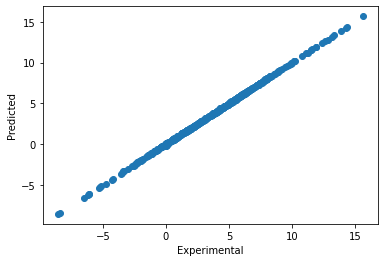

mae error on test set   : 0.040
mse error on test set   : 0.002
explained variance score: 1.000
slope     :  0.9998350403412305
r value   :  0.999919610652183
r^2       :  0.9998392277668133
p value   :  0.0
std error :  0.0005614145981794718
   index     value
0     x1  0.311814
1     x2  0.444781
2     x3  0.000000
3  x1,x2  0.000000
4  x1,x3  0.239259
5  x2,x3  0.000000

                 Resampling

Progress: |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete

                 Sensitivity Indices

   index     value  lower_CI  u

In [6]:
function = ishigami
samples = 512
variables = 2
design = 'sobol'

hdmr = rshdmr(function(samples, variables, design), 
              poly_order=8,
              regression_type = 'ard', 
              manual_best_neurons_selection=True ,
              min_best_neurons_count = 200,
              n_jobs = 4,
              hdmr_order=2
              )

hdmr.auto()

print('')
print('================================================')
print('                 Resampling')
print('================================================')
print('')
hdmr.resample(resamples=500, alpha=1)

print('')
print('================================================')
print('                 Sensitivity Indices')
print('================================================')
print('')

print(hdmr.sobol_indexes)

In [9]:
total_effects(hdmr, labels=['x1', 'x2','x3'], lower_p = 0.025, upper_p = 0.975, alpha=1 )

x1 0.48904125797160436 0.5510729713796723 0.6439544560133822
x2 0.39431387748523117 0.444781132174185 0.5179533626302858
x3 0.2119893815162325 0.23925939174987645 0.2789261627137999


In [174]:
#hdmr.sobol_indexes.style
hdmr.sobol_indexes.loc[hdmr.sobol_indexes['value'] > 0.0001]

,index,value,lower_CI,upper_CI
0,x1,0.613830,0.555711,0.679456
1,x5,0.001467,0.001121,0.001882
2,x2,0.153552,0.138429,0.170504
3,x6,0.000998,0.000695,0.001387
4,x3,0.016831,0.014866,0.018851
5,x4,0.009384,0.008036,0.010764
6,"x1,x5",0.001712,0.001226,0.002227
7,"x1,x2",0.153794,0.138359,0.169780
8,"x1,x6",0.001145,0.000753,0.001686
9,"x1,x3",0.017165,0.015164,0.019385


In [175]:
hdmr.sobol_indexes['value'].sum()

0.987607616197076

In [8]:
hdmr.X

,x1,x2,x3
0,0.000000,0.000000,0.000000
1,1.570796,-1.570796,1.570796
2,-1.570796,1.570796,-1.570796
3,-0.785398,-0.785398,0.785398
4,2.356194,2.356194,-2.356194
...,...,...,...
507,-1.558524,-1.558524,0.994020
508,1.583068,1.583068,-2.147573
509,0.012272,-3.129321,-0.576777
510,-3.129321,0.012272,2.564816
